In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
# See https://duetosymmetry.com/code/latex-mpl-fig-tips/
plt.style.use("mda.mplstyle")

pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.

jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
        "CQG": {"onecol": 374.*pt}, # CQG is only one column
        # Add more journals below. Can add more properties to each journal
    }

my_width = jour_sizes["PRD"]["onecol"]
# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2

## RMSD of Zebrafish Hb only

In [2]:
from MDAnalysis.analysis import rms
#Read all the trajectories
protein_prod = mda.Universe('zeb_hb_only_sim/sys_prod/prod_zeb_hb_only.gro', 'zeb_hb_only_sim/sys_prod/prod_zeb_hb_only_compact_compact.xtc')

R = rms.RMSD(protein_prod,  # universe to align
    protein_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_p = R.results.rmsd[:,1]
rmsd_p = R.results.rmsd[:,2]

  0%|          | 0/20001 [00:00<?, ?it/s]

## Radius of Gyration of Zebrafish Hb only

In [3]:
from tqdm import tqdm
group = protein_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(protein_prod.trajectory):
	Frame.append(ts.frame)
	times.append(protein_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrp_table = np.vstack((Frame, times, Rgyr)).T

100%|██████████| 20001/20001 [00:47<00:00, 421.42it/s]


## RMSD of Zebrafish Hb and PHZ Complex

In [4]:
from MDAnalysis.analysis import rms
#Read all the trajectories
complex_prod = mda.Universe('zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.gro', 'zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_compact_compact.xtc')

R = rms.RMSD(complex_prod,  # universe to align
    complex_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c = R.results.rmsd[:,1]
rmsd_c = R.results.rmsd[:,2]

  0%|          | 0/10001 [00:00<?, ?it/s]

## Radius of Gyration of Zebrafish Hb and PHZ Complex

In [5]:
from tqdm import tqdm
group = complex_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(complex_prod.trajectory):
	Frame.append(ts.frame)
	times.append(complex_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T

100%|██████████| 10001/10001 [00:21<00:00, 454.83it/s]


## RMSF: Protein backbone and Carbon alpha

In [6]:
c_alphas_p = protein_prod.select_atoms('backbone and name CA')
# I ran the protein for twice the time of the complex, so have to cut the protein data
R_p_half = rms.RMSF(c_alphas_p).run(start=0, stop=len(times_c)//2, verbose=True)

c_alphas_c = complex_prod.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run(verbose=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

In [7]:
mda.__version__

'2.8.0-dev0'

## H-bond analysis:

Note: as of today (20240929), the latest stable version of `mdanalysis-2.7.0` cannot import `GROMACS` tpr files from `gromacs-2024.2`, yielding this exception

```python
ValueError: Failed to construct topology from file zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.tpr with parser <class 'MDAnalysis.topology.TPRParser.TPRParser'>.
Error: Your tpx version is 133, which this parser does not support, yet
```

So we have to install the development version from GitHub. 

### Instructions:

```bash
$ conda create -n mdanalysis-develop numpy cython ipykernel ipywidgets
$ conda activate mdanalysis-develop
$ git clone --depth=50 https://github.com/MDAnalysis/mdanalysis.git
$ cd mdanalysis
$ git branch

* develop

$ pip install package/
$ pip install testsuite/ #Optional
$ python -c 'import MDAnalysis as mda; print(mda.__version__)'
2.8.0-dev0
```
Then, reload jupyter kernel in this new environment.

Background: [MDAnalysis example: Hydrogen Bonds](https://userguide.mdanalysis.org/stable/examples/analysis/hydrogen_bonds/hbonds.html)

In [8]:
#Giving full tpr file to include bonding info
u = mda.Universe("zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.tpr",\
            "zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_compact_compact.xtc")
phz = u.select_atoms('resname PHZ')
protein = u.select_atoms('protein')
num_residues = len(protein.residues)

Note that we're selecting PHZ and protein, so the selections need not be updated with each frame. Setting `update_selections=False` drastically speeds up the hbonds run.

In [9]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

hbonds_phz_prot = HBA(universe=u,
        donors_sel='resname PHZ',
        acceptors_sel='protein',
        update_selections=False
        )
hbonds_phz_prot.run(verbose=True)

  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, resname PHZ, and Acceptor, protein.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, resname PHZ, and Acceptor, protein.
  warnings.warn(


The average number of each type of hydrogen bond formed at each frame is likely more informative than the total number over the trajectory. This can be calculated for each hydrogen bond type as follows:

In [10]:
sorted_output = sorted(hbonds_phz_prot.count_by_type(), key=lambda x: float(x[2]), reverse=True)
for donor, acceptor, count in sorted_output:
    donor_resname, donor_type = donor.split(":")
    n_donors = u.select_atoms(f"resname {donor_resname} and type {donor_type}").n_atoms
    mean_count = 2 * int(count) / (hbonds_phz_prot.n_frames * n_donors)
    print(f"{donor} to {acceptor}: {mean_count:.3f}")

PHZ:hn to LEU:HC: 0.204
PHZ:hn to HID:NB: 0.150
PHZ:hn to LEU:O: 0.072
PHZ:hn to HID:CV: 0.069
PHZ:hn to HID:CR: 0.062
PHZ:nu to HID:NB: 0.114
PHZ:hn to LEU:CT: 0.030
PHZ:n8 to LEU:O: 0.071
PHZ:hn to HID:H4: 0.023
PHZ:n8 to LEU:HC: 0.069
PHZ:n8 to HID:NB: 0.059
PHZ:hn to VAL:HC: 0.018
PHZ:hn to HID:H5: 0.015
PHZ:hn to TRP:HA: 0.015
PHZ:hn to HID:NA: 0.014
PHZ:n8 to ILE:HC: 0.039
PHZ:nu to LEU:O: 0.039
PHZ:hn to LEU:C: 0.013
PHZ:n8 to VAL:HC: 0.031
PHZ:hn to HID:CC: 0.010
PHZ:hn to HID:H1: 0.009
PHZ:hn to PHE:HA: 0.008
PHZ:nu to LEU:HC: 0.023
PHZ:nu to ASN:O: 0.022
PHZ:hn to PHE:HC: 0.004
PHZ:hn to HID:H: 0.004
PHZ:nu to TYR:O: 0.010
PHZ:n8 to PHE:HA: 0.009
PHZ:hn to LYS:HC: 0.002
PHZ:hn to ILE:HC: 0.002
PHZ:hn to VAL:CT: 0.002
PHZ:hn to LEU:H: 0.002
PHZ:nu to PHE:H1: 0.003
PHZ:n8 to ASN:HC: 0.003
PHZ:hn to VAL:O: 0.001
PHZ:hn to PHE:CA: 0.001
PHZ:hn to TRP:CA: 0.001
PHZ:n8 to HID:H4: 0.002
PHZ:nu to HID:O: 0.002
PHZ:hn to PHE:O: 0.001
PHZ:nu to PHE:HC: 0.002
PHZ:n8 to TYR:O: 0.002
PHZ:

In [11]:
from tqdm import tqdm
from collections import Counter

acceptors = []

for hbond in tqdm(hbonds_phz_prot.results.hbonds):
    frame, donor_ix, hydrogen_ix, acceptor_ix = hbond[:4].astype(int)
    u.trajectory[frame]
    atoms = u.atoms[[donor_ix, hydrogen_ix, acceptor_ix]]
    acceptors.append(f'{str(u.atoms[acceptor_ix].resid)}-{u.atoms[acceptor_ix].resname}')
    
print("The acceptors that participate in h-bonding vs number of frames are:\n")

acceptors_dict = dict(Counter(acceptors))
acceptors_dict

  0%|          | 0/13628 [00:00<?, ?it/s]

100%|██████████| 13628/13628 [00:27<00:00, 499.77it/s]

The acceptors that participate in h-bonding vs number of frames are:



{'93-LEU': 1931,
 '89-HID': 5549,
 '60-HID': 757,
 '88-LEU': 3544,
 '85-LEU': 156,
 '47-TRP': 250,
 '64-ILE': 232,
 '43-TYR': 68,
 '95-VAL': 478,
 '63-THR': 2,
 '103-LEU': 66,
 '33-MET': 14,
 '45-SER': 1,
 '99-ASN': 131,
 '100-PHE': 58,
 '44-PHE': 86,
 '30-LEU': 104,
 '92-LYS': 38,
 '91-PHE': 163}

### H-bond parameters
  - *d_h_cutoff* (Å) [1.2] : Distance cutoff used for finding donor-hydrogen pairs
  - *d_a_cutoff* (Å) [3.0] : Distance cutoff for hydrogen bonds. This cutoff refers to the D-A distance.
  - *d_h_a_angle_cutoff* (degrees) [150] : D-H-A angle cutoff for hydrogen bonds.

### Nothing to see if we reverse donor and acceptor

In [83]:
hbonds_prot_phz = HBA(universe=u,
        acceptors_sel='resname PHZ',
        donors_sel='protein',
        update_selections=False
        )
hbonds_prot_phz.run(verbose=True)

  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, protein, and Acceptor, resname PHZ.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, protein, and Acceptor, resname PHZ.
  warnings.warn(


In [84]:
#Sort by the number of hydrogen bonds per donor
sorted_output = sorted(hbonds_prot_phz.count_by_type(), key=lambda x: float(x[2]), reverse=True)
for donor, acceptor, count in sorted_output[:10]:
    donor_resname, donor_type = donor.split(":")
    n_donors = u.select_atoms(f"resname {donor_resname} and type {donor_type}").n_atoms
    mean_count = 2 * int(count) / (hbonds_prot_phz.n_frames * n_donors)
    print(f"{donor} to {acceptor}: {mean_count:.3f}")

HID:NA to PHZ:n8: 0.001
HID:H to PHZ:hn: 0.001
HID:NA to PHZ:hn: 0.000
HID:NA to PHZ:nu: 0.000
HID:NA to PHZ:ca: 0.000
ASN:H to PHZ:ha: 0.000
TRP:NA to PHZ:hn: 0.000


## Plot everything

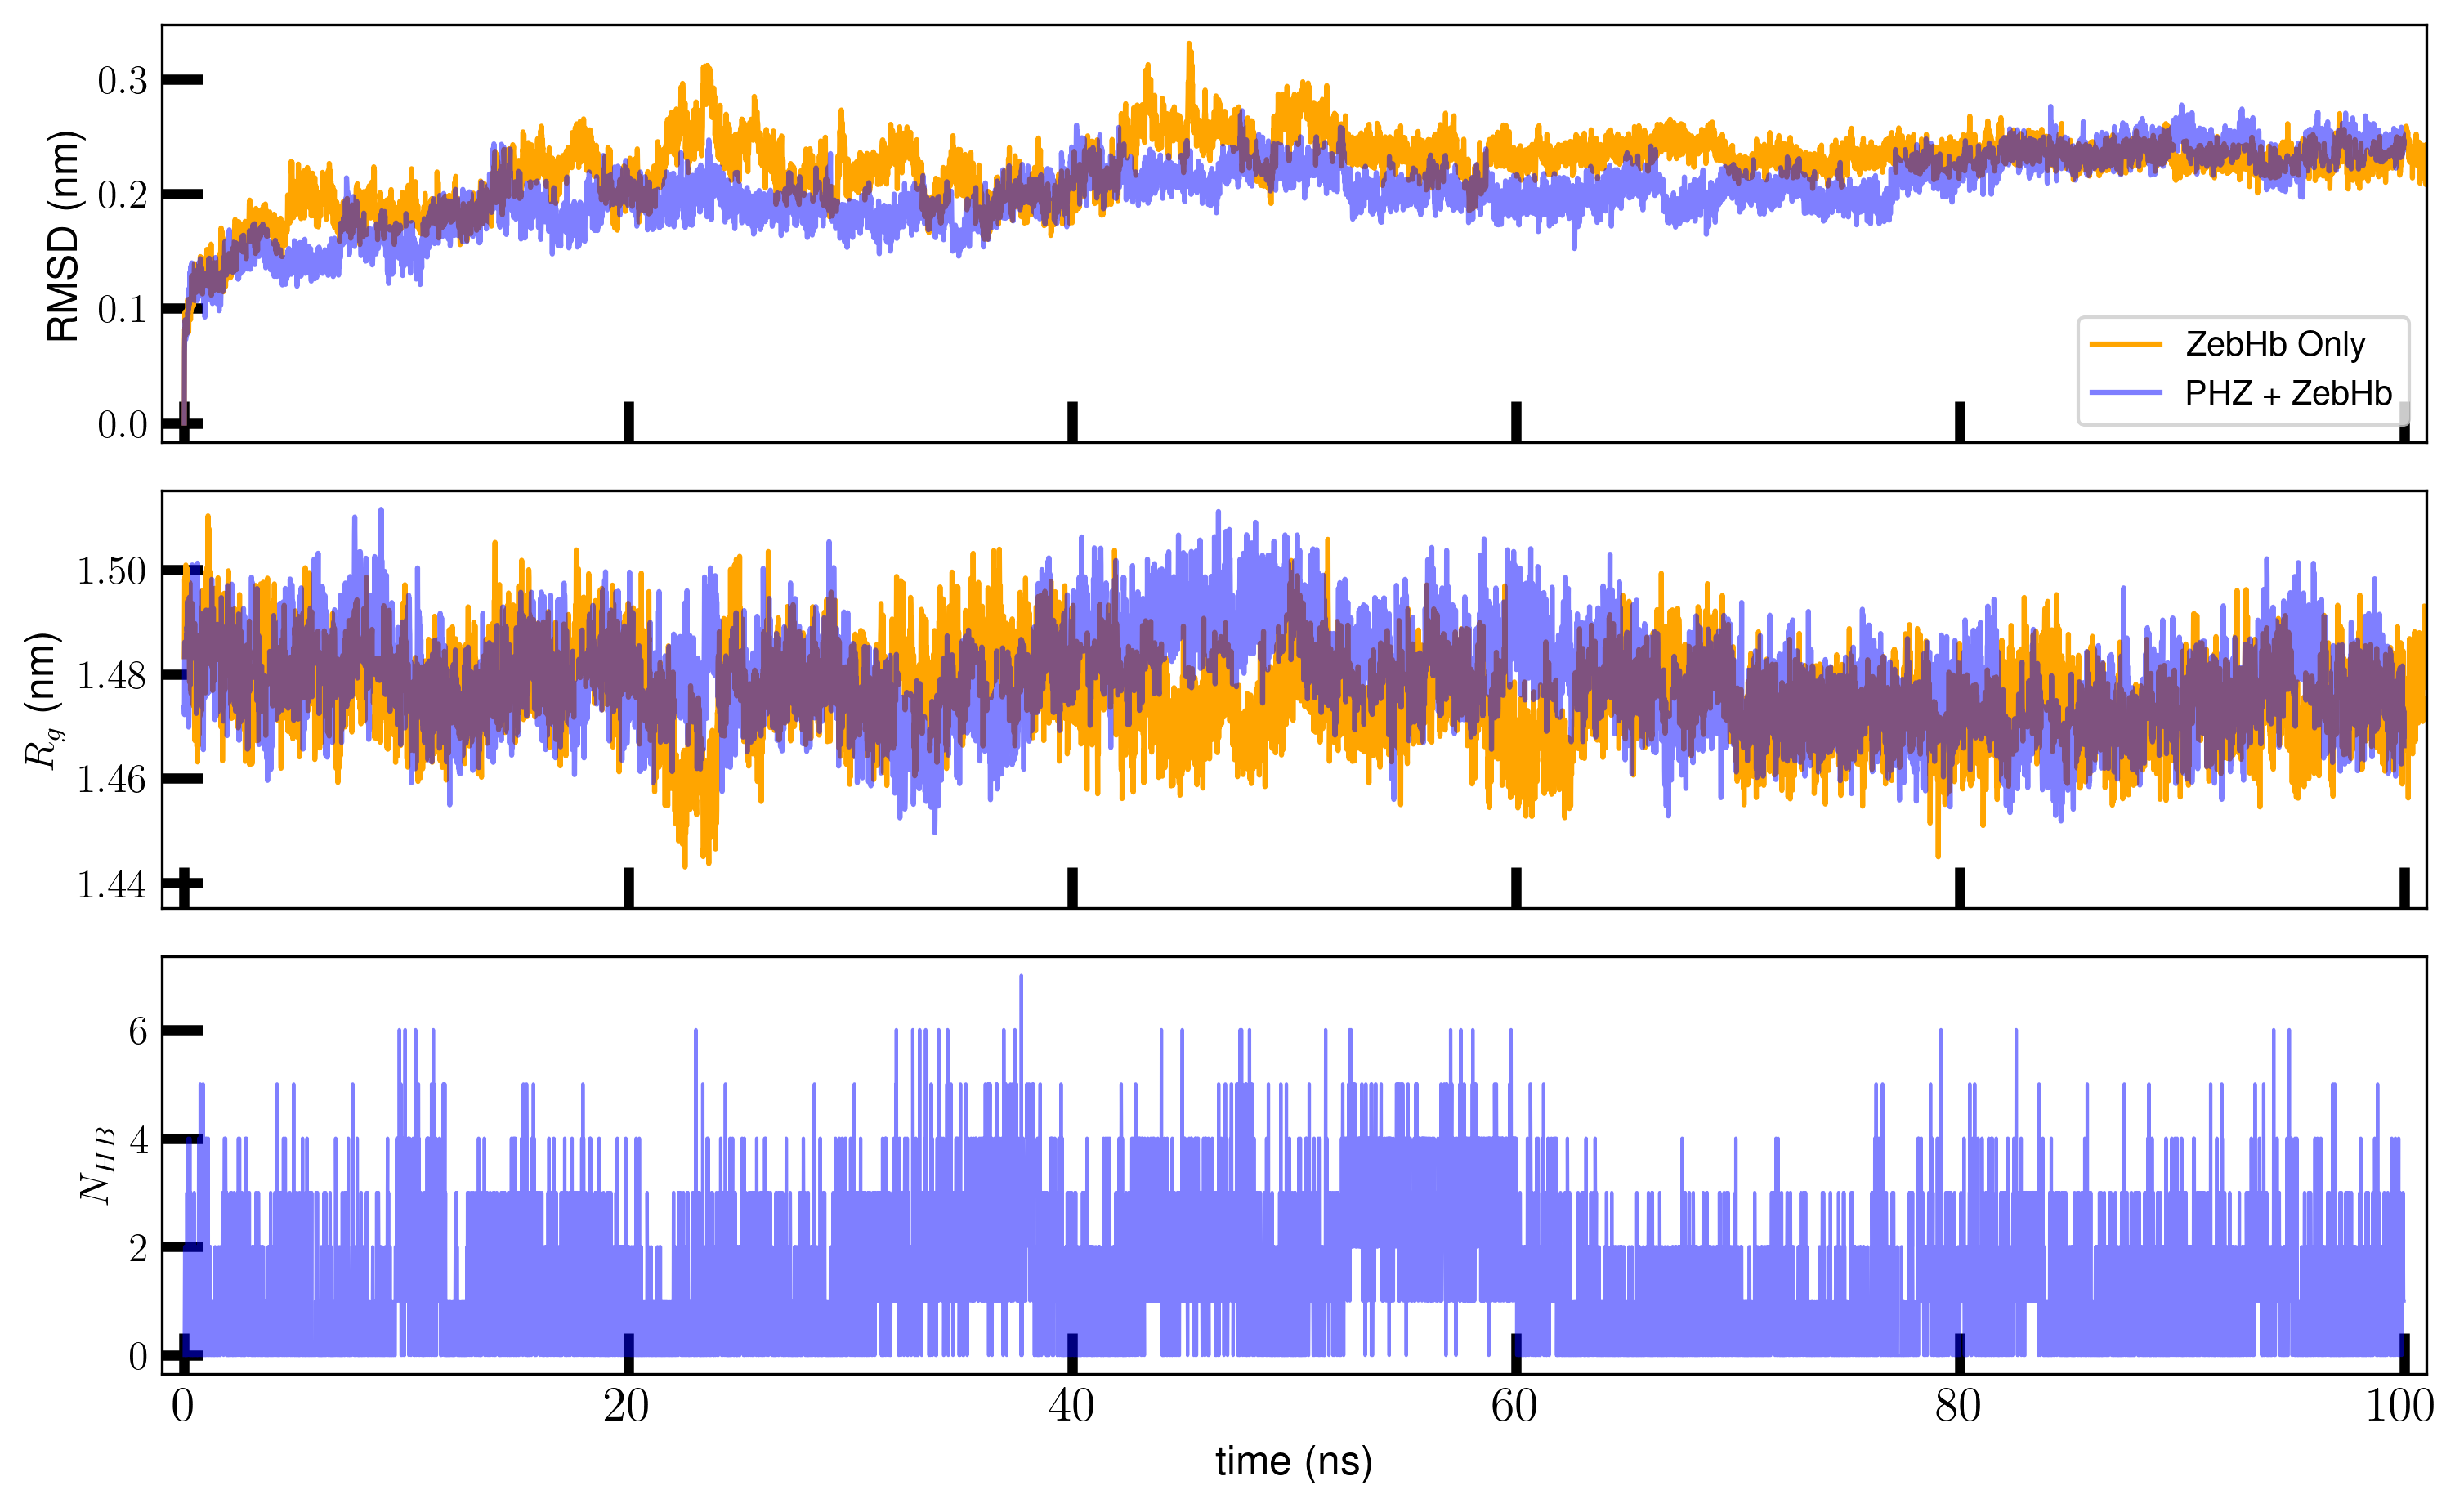

In [12]:
npanels = 3
fig, axs = plt.subplots(npanels,1, sharex=True, tight_layout=True, figsize = (npanels * my_width, npanels*my_width/golden))

ax_rmsd = axs[0]
ax_rmsd.set_ylabel(r'RMSD (nm)');

ax_rmsd.plot(times_p/1000, rmsd_p/10, label="ZebHb Only", 
            color='orange')
ax_rmsd.plot(times_c/1000, rmsd_c/10, label="PHZ + ZebHb", 
            alpha=0.5, color='blue')

ax_rmsd.legend()

ax_rg = axs[1]
ax_rg.plot(Rgyrp_table[:,1]/1000, Rgyrp_table[:,2]/10, 
        label="ZebHb Only", color='orange')
ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, 
        label="PHZ + ZebHb", alpha=0.5,color='blue')
ax_rg.set_ylabel(r'$R_g$ (nm)');

ax_bonds = axs[2]
ax_bonds.set_xlabel(r'time (ns)');
ax_bonds.set_xlim(-1, 101);

ax_bonds.plot(hbonds_phz_prot.times/1000, hbonds_phz_prot.count_by_time(), 
            lw=1, label="PHZ + ZebHb", alpha=0.5,color='blue')

#plt.title("Number of hydrogon bonds over time", weight="bold")
ax_bonds.set_ylabel(r"$N_{HB}$")
plt.savefig("time-series-plots.png", dpi=600)
plt.show()


/tmp/ipykernel_210415/2600845662.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


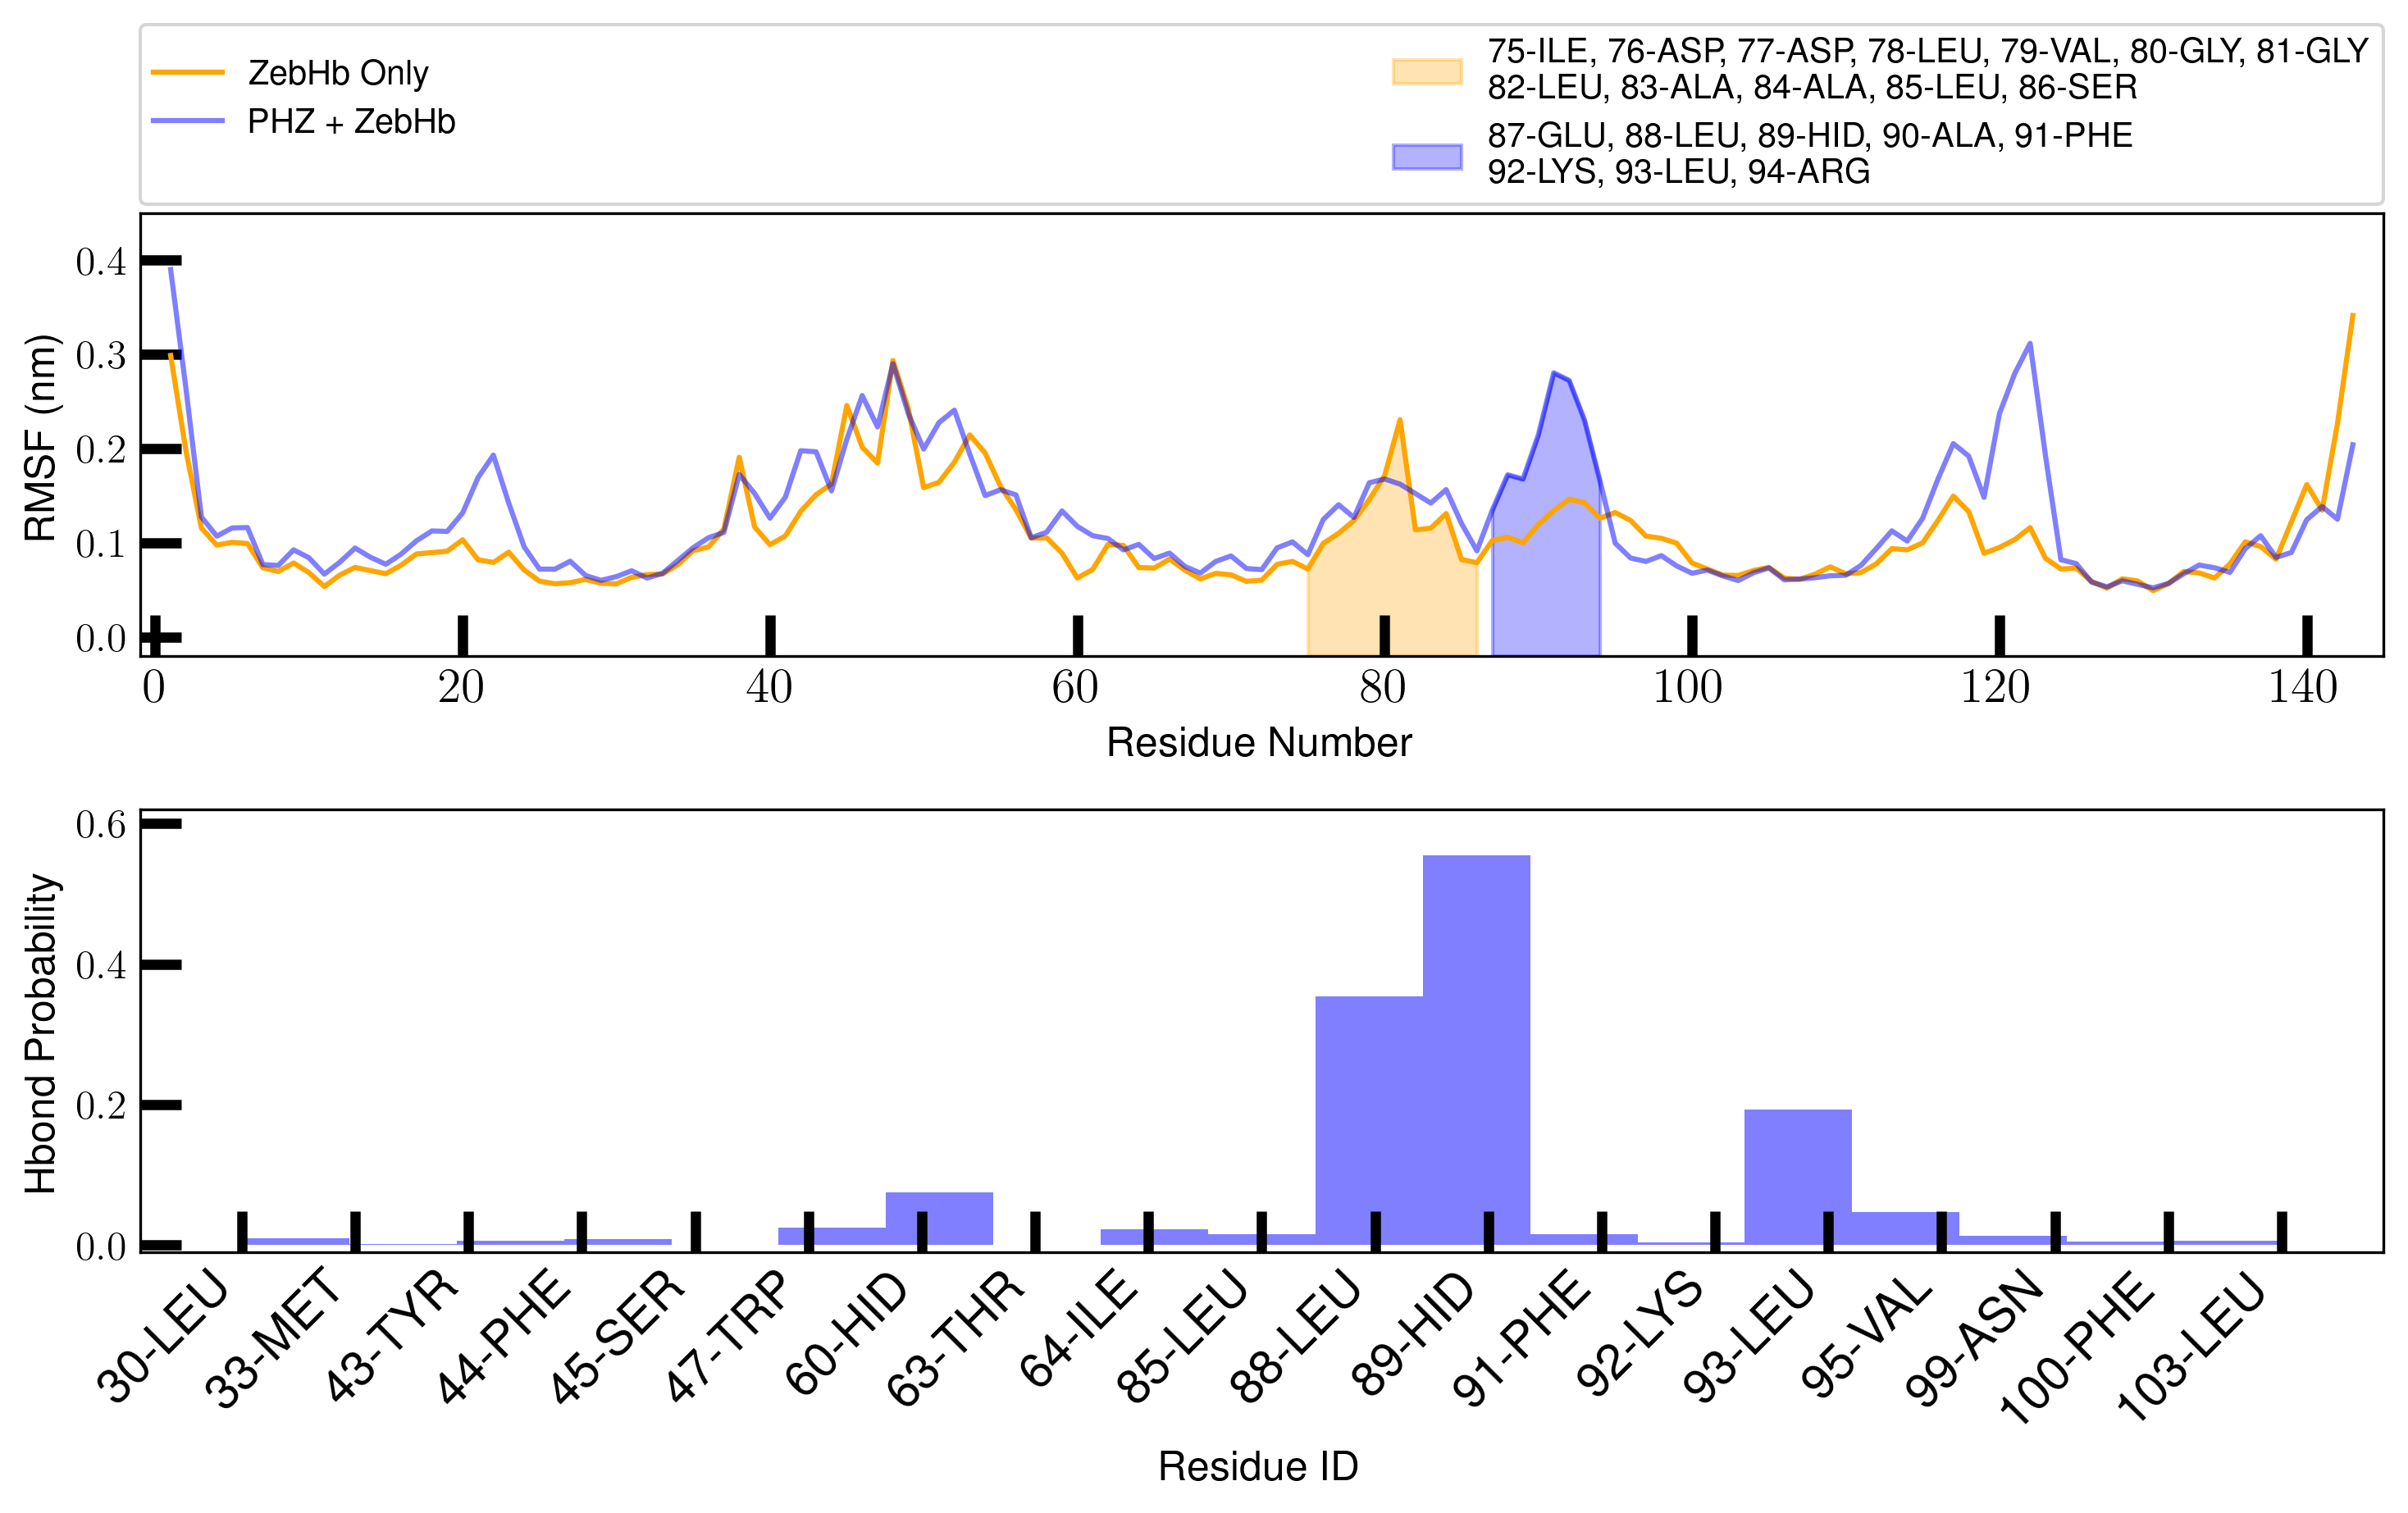

In [13]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (npanels*my_width, npanels*my_width/golden))

line_p, = ax1.plot(c_alphas_p.resids, R_p_half.results.rmsf/10, label="ZebHb Only", 
                color="orange")
line_c, = ax1.plot(c_alphas_c.resids, R_c.results.rmsf/10, label="PHZ + ZebHb", 
                alpha=0.5, color="blue")

def fill_resids(ax, resids, rmsf, label, color):
    resnames = ''
    for idx, resid in enumerate(resids):
        residues = protein_prod.select_atoms(f'resid {resid}')
        resnames += f'{resid}-{residues.resnames[0]}'
        if idx == len(resids)//2:
            resnames += '\n'
        else:
            resnames += ', ' if resid != resids[-1] else '' 
        
    ax.fill_between(resids, -0.02, rmsf[resids-1]/10, alpha=0.3, label=resnames,color=color)

fill_resids(ax1, np.arange(75, 87), R_p_half.results.rmsf, "ZebHb Only",line_p.get_color())
fill_resids(ax1, np.arange(87, 95), R_c.results.rmsf, "PHZ + ZebHb",line_c.get_color())


ax1.set_xlabel('Residue Number')
ax1.set_ylabel('RMSF (nm)')
ax1.set_xlim(-1, 145)
ax1.set_ylim(-0.02, 0.45)
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncols=2, mode="expand", borderaxespad=0.)

sorted_acceptors = sorted(acceptors, key=lambda x: int(x.split('-')[0]))

ax2.hist(sorted_acceptors, bins=len(set(sorted_acceptors)),
        weights=np.ones(len(sorted_acceptors))/hbonds_phz_prot.n_frames, color= "blue", alpha=0.5, align='mid')

ax2.set_xlabel('Residue ID')
ax2.set_ylabel("Hbond Probability")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_ylim(-0.01, 0.62)
plt.savefig("rmsf-hbonds.png", dpi=600)
plt.tight_layout()

## Refined H-bond analysis

Take the top three residues from the histogram above and rerun hbonds with each uniquely selected, the hbonds donor and acceptor atoms keep changing.

In [15]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

resnums = [88, 89, 93]
npanels = len(resnums)
hbonds_top3 = []

for rn in resnums:
        hb = HBA(universe=u,
                donors_sel='resname PHZ',
                acceptors_sel='resnum '+str(rn),
                update_selections=False
                )
        hb.run(verbose=True)
        hbonds_top3.append(hb)

  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, resname PHZ, and Acceptor, resnum 88.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, resname PHZ, and Acceptor, resnum 88.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, resname PHZ, and Acceptor, resnum 89.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, resname PHZ, and Acceptor, resnum 89.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, resname PHZ, and Acceptor, resnum 93.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, resname PHZ, and Acceptor, resnum 93.
  warnings.warn(


/tmp/ipykernel_210415/3661713824.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize='small')
/tmp/ipykernel_210415/3661713824.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize='small')
/tmp/ipykernel_210415/3661713824.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize='small')


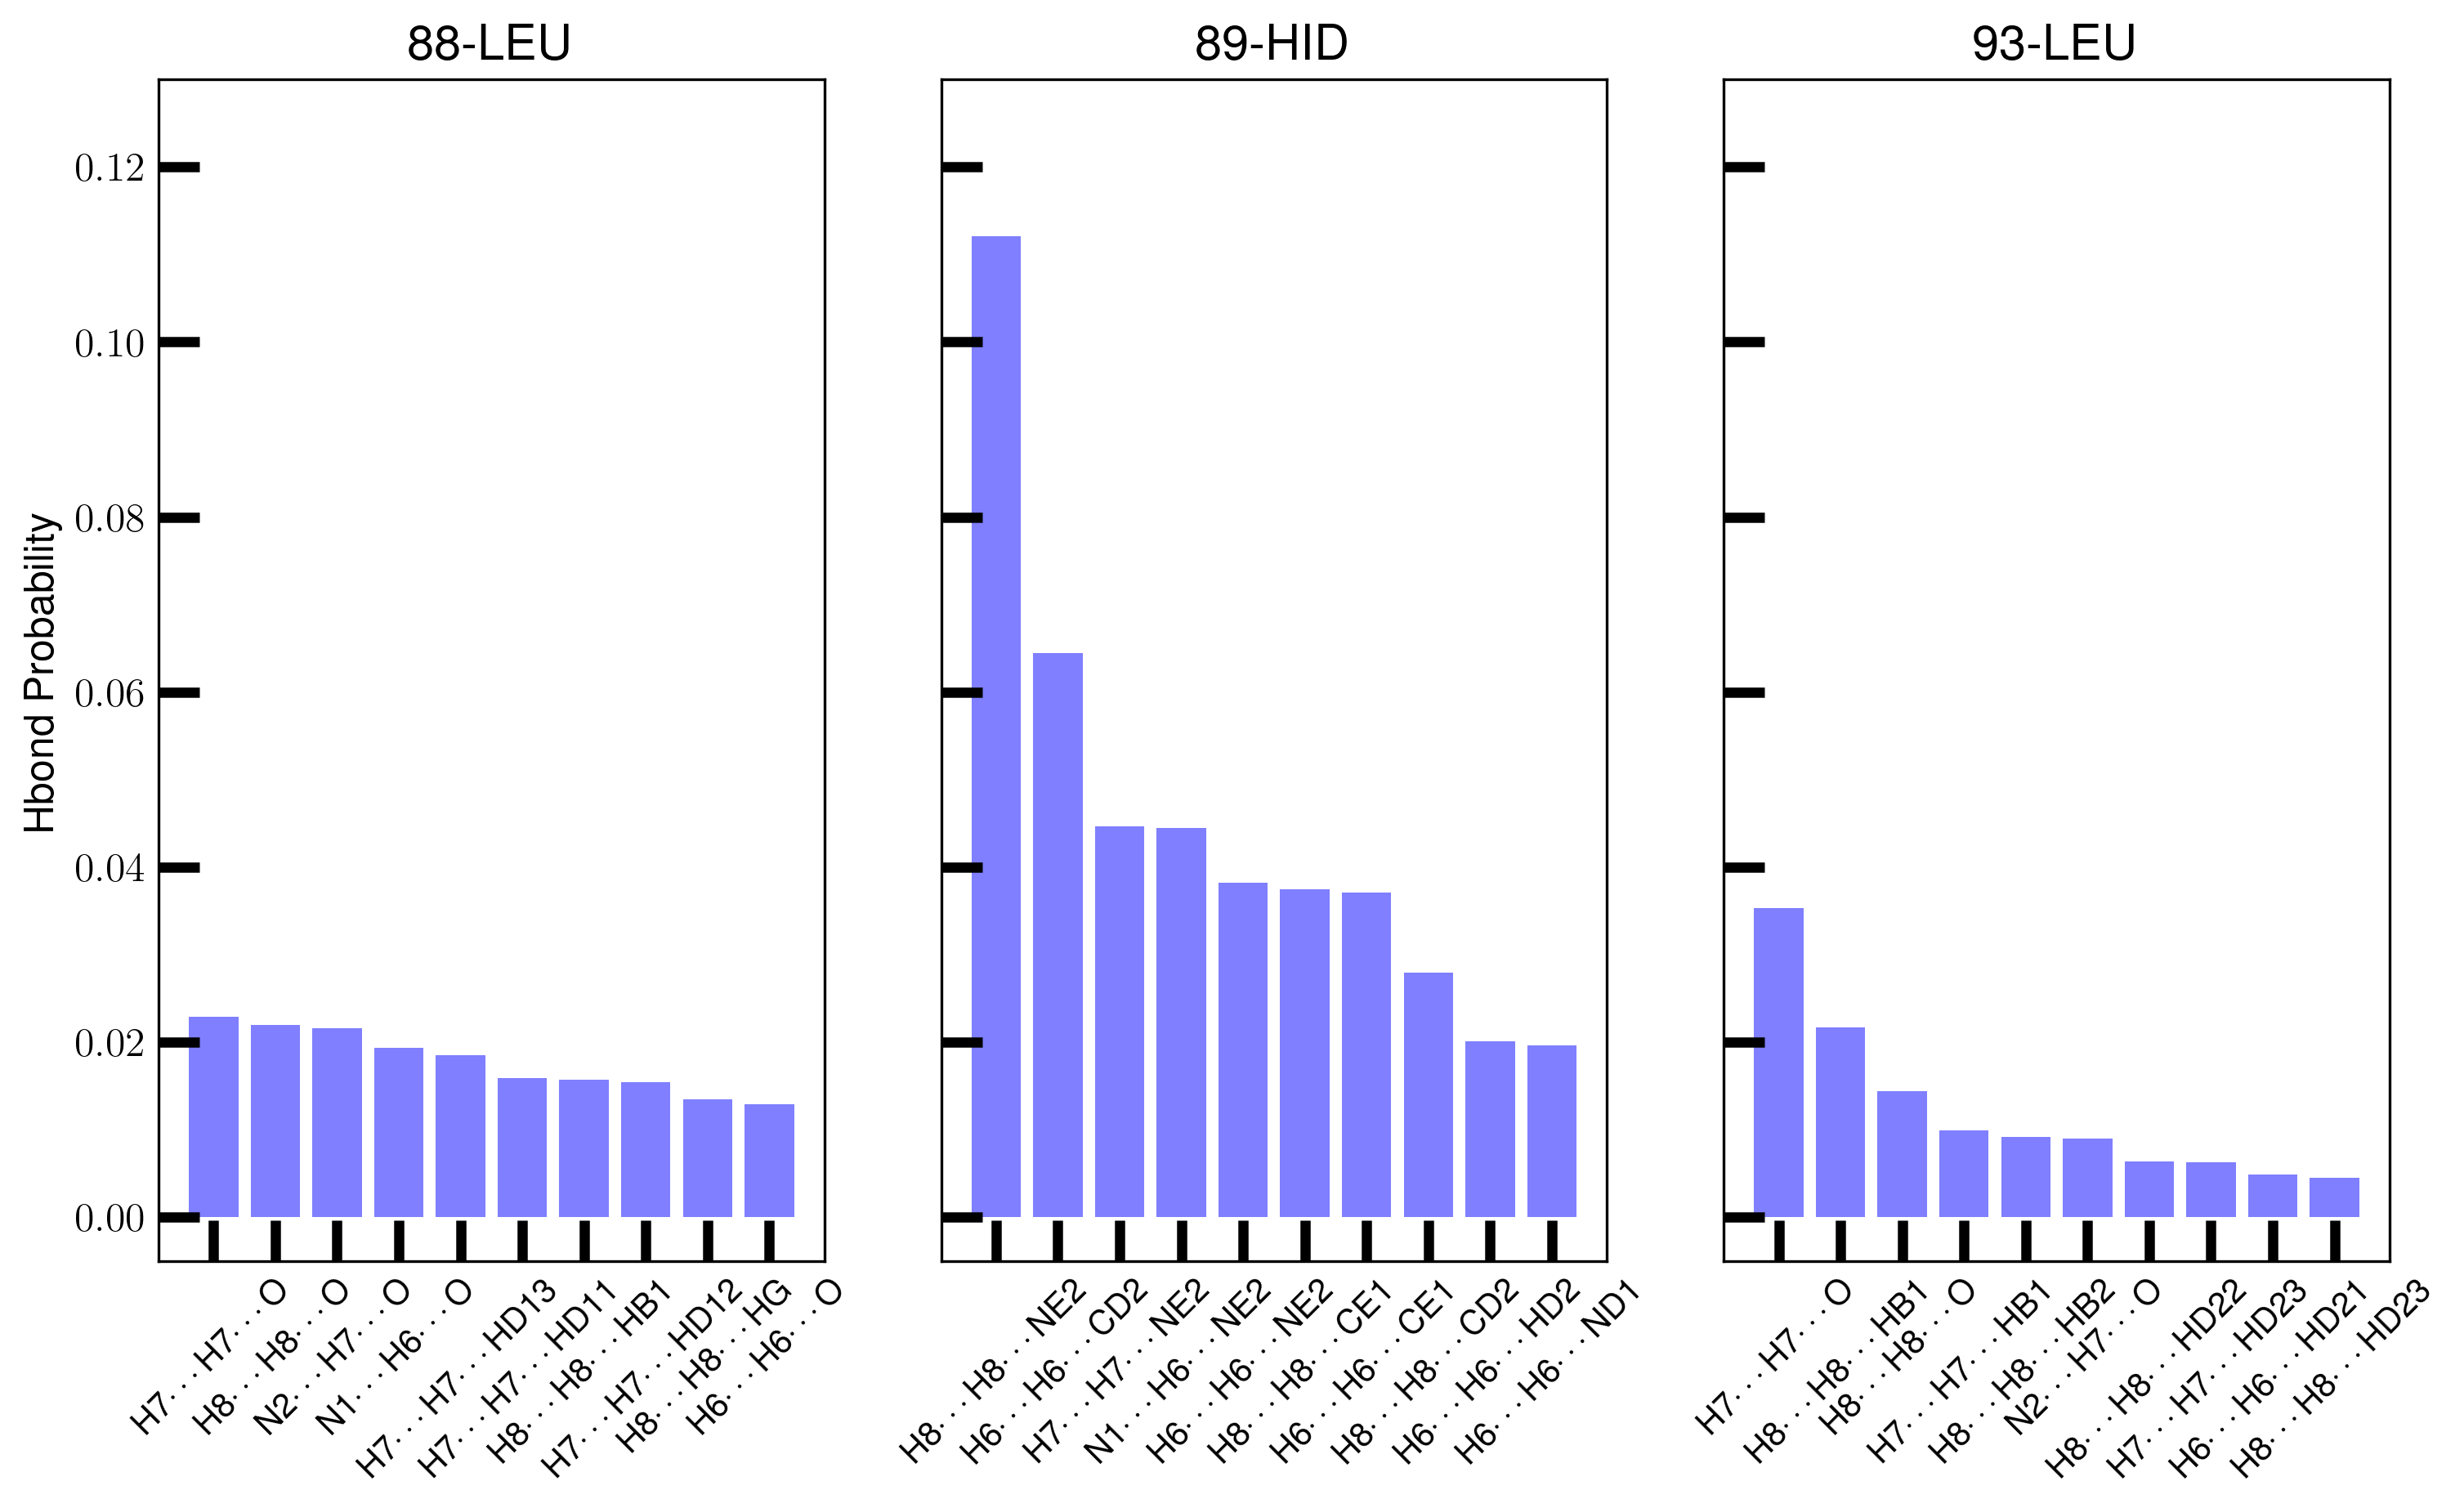

In [341]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
frames = u.trajectory.n_frames
fig, axs = plt.subplots(1, npanels, 
                        figsize=(npanels*my_width, npanels*my_width/golden),
                                sharey=True, tight_layout=True)   
for i, rn in enumerate(resnums):
        data_dict = {}
        counts = hbonds_top3[i].count_by_ids()
        for donor, hydrogen, acceptor, count in counts[:10]:
                d, h, a = u.atoms[donor], u.atoms[hydrogen], u.atoms[acceptor]
                data_dict[fr"{d.name}$\cdots${h.name}$\cdots${a.name}"]=count/frames
        
        probs = [value for value in data_dict.values()]
        axs[i].bar(data_dict.keys(), probs, color='blue', alpha=0.5)
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize='small')
        axs[i].set_ylim(-0.005, 0.13)

axs[0].set_ylabel("Hbond Probability")
axs[0].set_title("88-LEU")
axs[1].set_title("89-HID")
axs[2].set_title("93-LEU");
plt.savefig("hbonds-refined.png", dpi=600)

## Hydrogen Bond lifetimes via correlation analysis

For each of the bond pairs selected from the gaggle above, we plot 

\begin{equation*}
C^{ij}_x(t)=\left\langle\frac{h_{i j}\left(t_0\right) h_{i j}\left(t_0+t\right)}{h_{i j}\left(t_0\right)^2}\right\rangle_{t_0}
\end{equation*}

where 

\begin{equation*}
h_{ij} = \begin{cases}
1 & \text{If hbond: } i \to j\\
0 & \text{otherwise }
\end{cases}
\end{equation*}

The subscript in $C_x$, $x$, can be either $C$ (continuous) or $I$ (intermittent). When $x=C$, a bond, once broken, is assumed to never form again even if conditions are optimal, whereas when $x=I$, bond formation is counted regardless of history. Thus, a low $C_C(t)$ and high $C_I(t)$ indicates the dominance of intermittent hydrogen bonds. The curves are fit to exponential decays to yield bond life times.

**Note:** In this simulation, all the hydrogen bonds seem to be intermittent, as the bond probabilities are very low.

### List most frequent bonds

Let’s first find the 3 most prevalent hydrogen bonds from each of the chosen residues.

In [197]:
from tqdm import tqdm
import pandas as pd

hbonds_top3each = []

for hb in tqdm(hbonds_top3):
    counts = hb.count_by_ids()
    hbonds_top3each.append(counts[:3])
    lines = []
    for donor, hydrogen, acceptor, count in counts[:10]:
        d, h, a = u.atoms[donor], u.atoms[hydrogen], u.atoms[acceptor]
        lines.append(f"{d.name}<-->{h.name}<-->{a.resid}-{a.resname} {a.name} count={count}")
    
    df = pd.DataFrame(sorted(lines), columns=['Hydrogen Bond'])
    print(df)


100%|██████████| 3/3 [00:00<00:00, 194.62it/s]

                       Hydrogen Bond
0     H6<-->H6<-->88-LEU O count=129
1  H7<-->H7<-->88-LEU HD11 count=159
2  H7<-->H7<-->88-LEU HD12 count=154
3  H7<-->H7<-->88-LEU HD13 count=185
4     H7<-->H7<-->88-LEU O count=229
5   H8<-->H8<-->88-LEU HB1 count=157
6    H8<-->H8<-->88-LEU HG count=135
7     H8<-->H8<-->88-LEU O count=220
8     N1<-->H6<-->88-LEU O count=194
9     N2<-->H7<-->88-LEU O count=216
                       Hydrogen Bond
0   H6<-->H6<-->89-HID CD2 count=645
1   H6<-->H6<-->89-HID CE1 count=371
2   H6<-->H6<-->89-HID HD2 count=201
3   H6<-->H6<-->89-HID ND1 count=196
4   H6<-->H6<-->89-HID NE2 count=382
5   H7<-->H7<-->89-HID NE2 count=447
6   H8<-->H8<-->89-HID CD2 count=280
7   H8<-->H8<-->89-HID CE1 count=375
8  H8<-->H8<-->89-HID NE2 count=1121
9   N1<-->H6<-->89-HID NE2 count=445
                      Hydrogen Bond
0  H6<-->H6<-->93-LEU HD21 count=49
1   H7<-->H7<-->93-LEU HB1 count=99
2  H7<-->H7<-->93-LEU HD23 count=63
3    H7<-->H7<-->93-LEU O count=353
4  H8<

In [351]:
hbonds_top9 = np.array(hbonds_top3each).reshape(9,4)
sorted_hbonds_top9 = hbonds_top9[hbonds_top9[:, -1].argsort()][::-1]
sorted_hbonds_top9

array([[2235, 2235, 1332, 1121],
       [2232, 2232, 1333,  645],
       [2234, 2234, 1332,  447],
       [2234, 2234, 1407,  353],
       [2234, 2234, 1319,  229],
       [2235, 2235, 1319,  220],
       [2235, 2235, 1394,  217],
       [2233, 2234, 1319,  216],
       [2235, 2235, 1407,  144]])

Now we’ll calculate the lifetime of these hydrogen bonds. To do this, the simplest way is to run `HydrogenBondAnalysis` for each hydrogen bond then use the `lifetime` method. It is very efficient to find hydrogen bonds between two specific atoms, especially with `update_selections=False`.

In [352]:
# Run hbonds analysis serially and store the results
hbond_results = []
for hbond in sorted_hbonds_top9:
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds = HydrogenBondAnalysis(
        universe=u,
        hydrogens_sel=f"index {h_ix}",
        acceptors_sel=f"index {a_ix}",
        update_selections=False
    )
    tmp_hbonds.run(verbose=True)
    hbond_results.append(tmp_hbonds)

  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, None, and Acceptor, index 1332.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, None, and Acceptor, index 1332.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, None, and Acceptor, index 1333.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, None, and Acceptor, index 1333.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, None, and Acceptor, index 1407.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, None, and Acceptor, index 1407.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, None, and Acceptor, index 1319.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, None, and Acceptor, index 1319.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, None, and Acceptor, index 1394.
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, None, and Acceptor, index 1394.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

In [365]:
import multiprocessing
tau_max = 200
intermittency = 20
hbond_lifetimes = []
labels = [] # for plotting
def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
        intermittency=intermittency
    )
    return np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
pool = multiprocessing.Pool(9)
hbond_lifetimes = pool.map(calculate_lifetime, hbond_results)
pool.close()
pool.join()

hbond_lifetimes = np.array(hbond_lifetimes)

for d,h,a,c in sorted_hbonds_top9:
    donor, hydrogen, acceptor = u.atoms[d], u.atoms[h], u.atoms[a]
    labels.append(fr"{donor.name}$\cdots${hydrogen.name}$\cdots${acceptor.resid}-{acceptor.resname} {acceptor.name}")


Finally, we can estimate the lifetime by fitting to exponential function (see references below)

\begin{equation*}
C_I(t) = A_1 e^{-t/\tau_1} + A_2 e^{-t/\tau_2} + \left(1-A_1 - A_2\right) e^{-t/\tau_3}
\end{equation*}

Here, the last term is said to contribute to the intermittent nature of the hydrogen bonds. The bond lifetime is given by the numerical integration

\begin{equation*}
\tau_I = \int^\infty_0 C_I(t) \mathrm{d}t.
\end{equation*}

/tmp/ipykernel_210415/4270251309.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[0.5, 10, 0.5, 20, 0.1, 30])


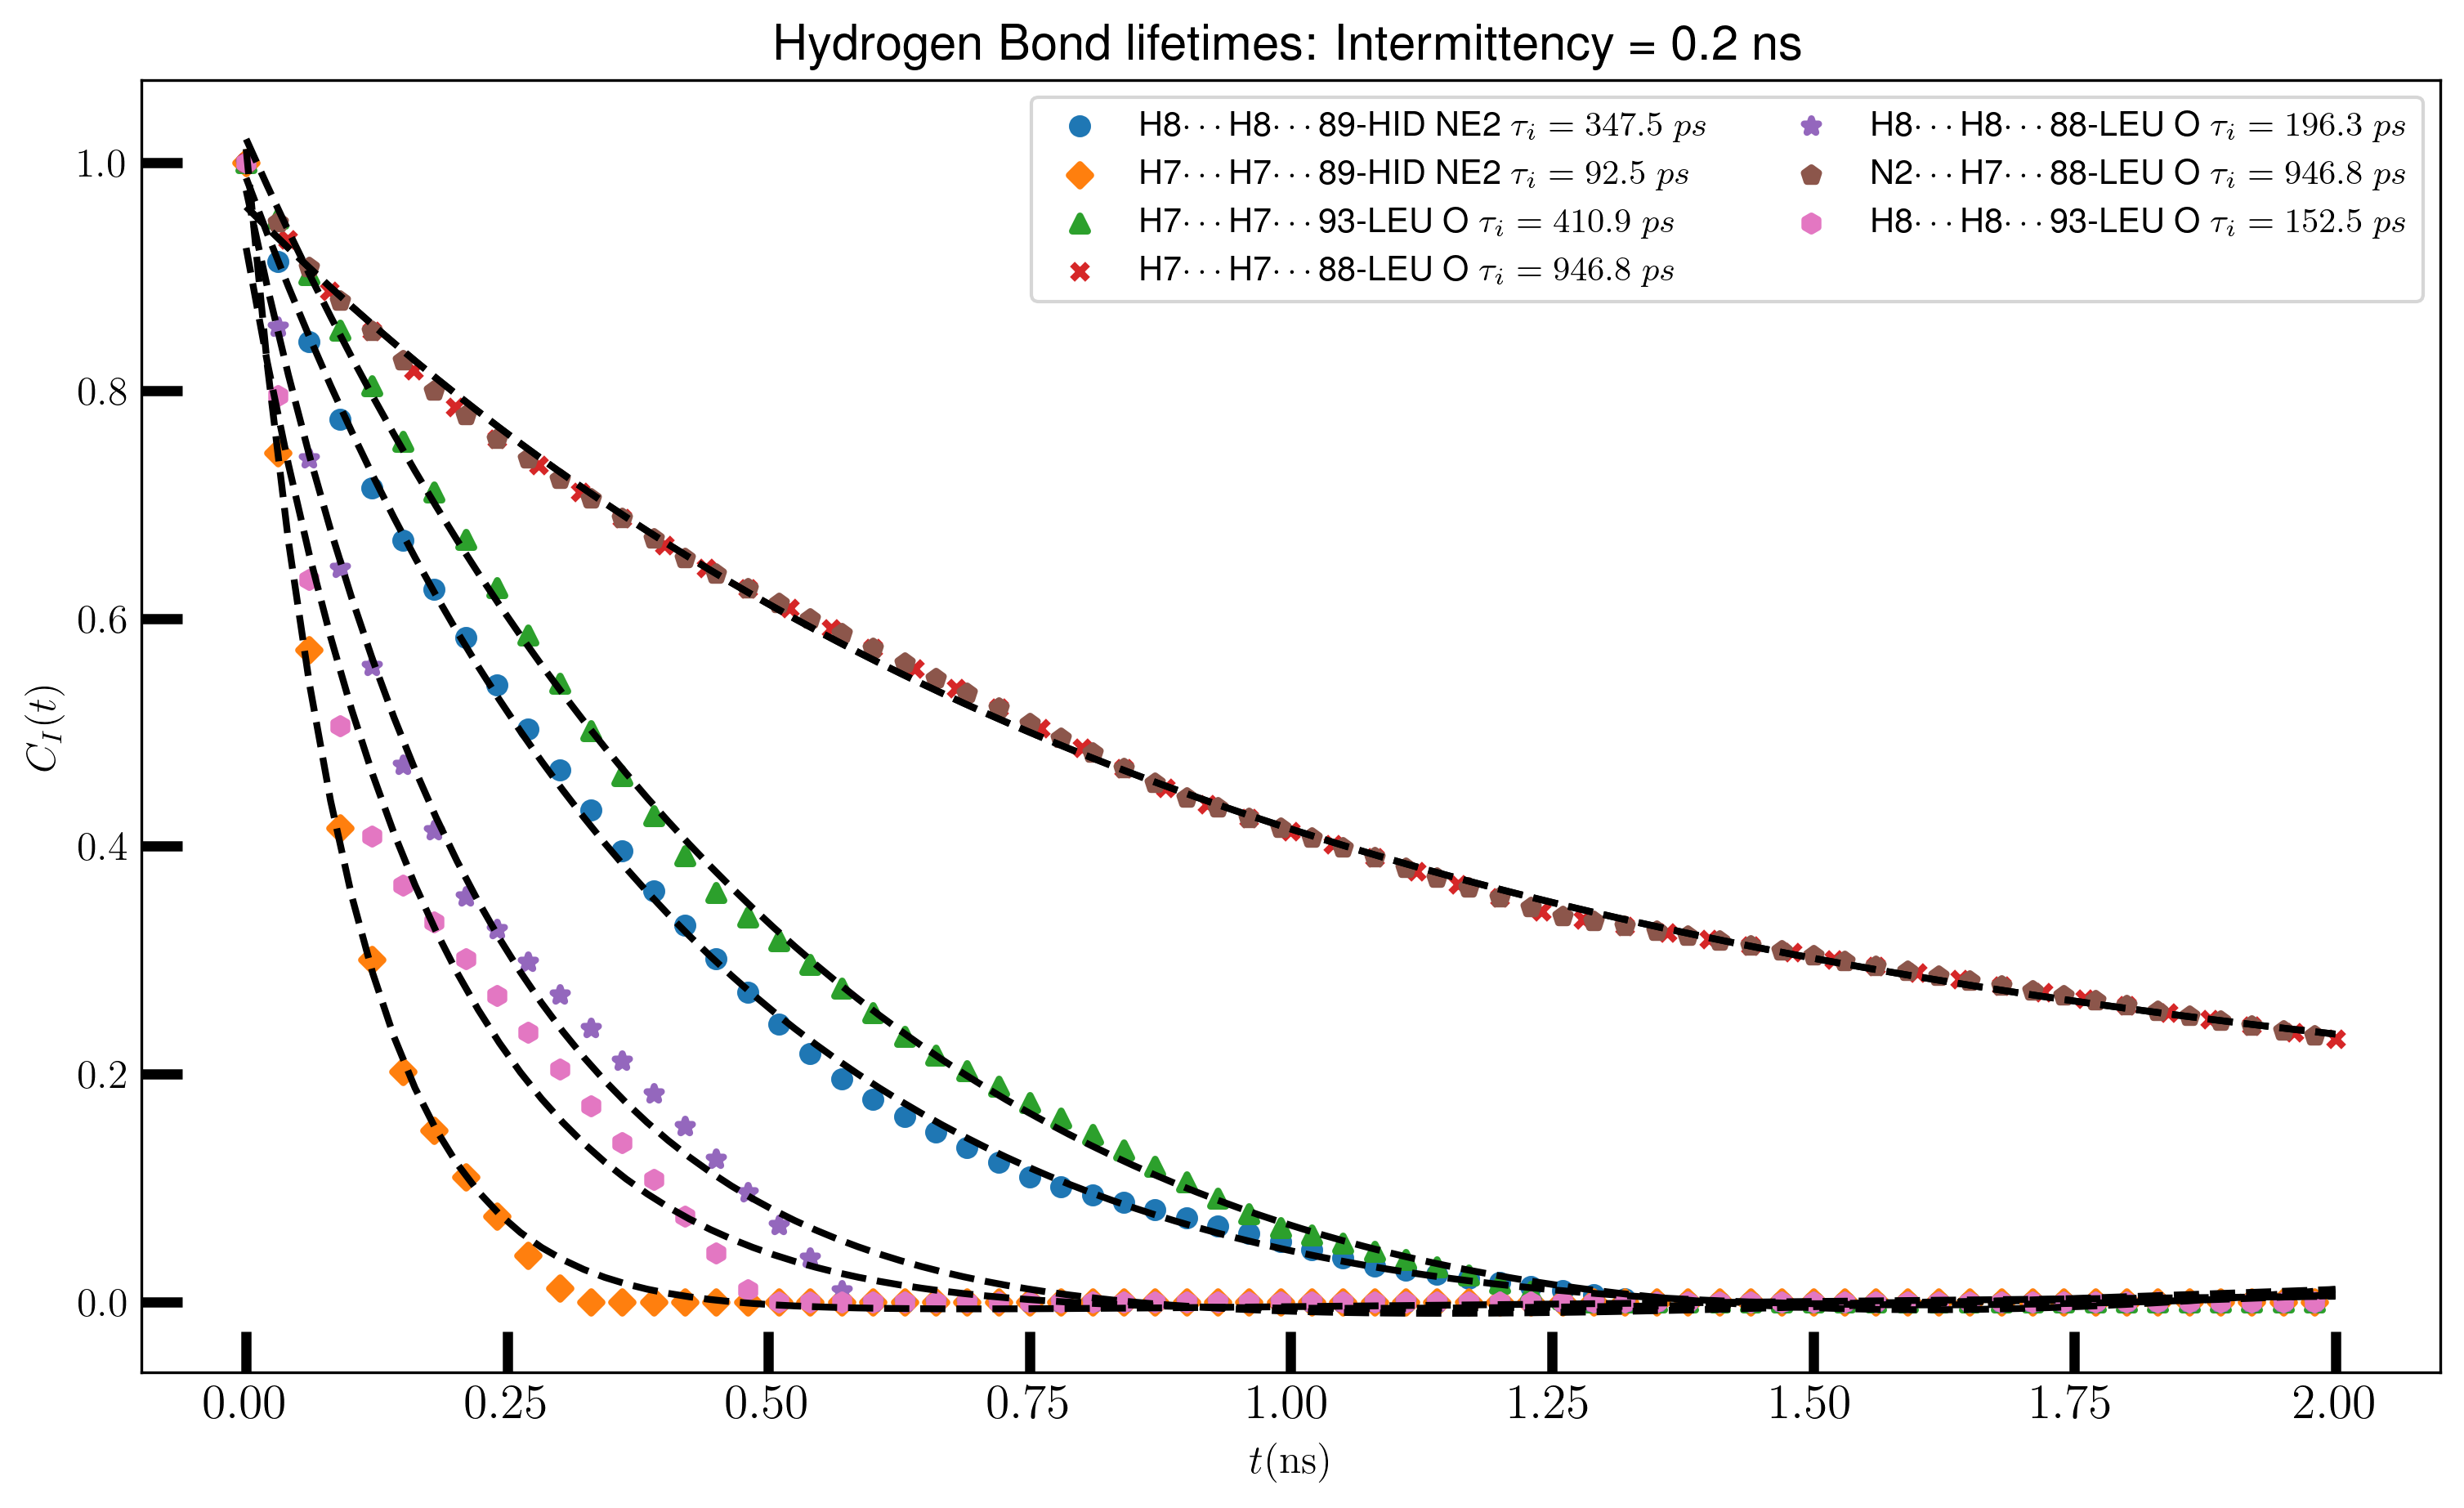

In [412]:
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Fit exponential decay
def hbond_corr(x, A1, tau1, A2, tau2, A3, tau3):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2) + A3 * np.exp(-x/tau3)

intermittency_time = intermittency * u.trajectory.dt/1000
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(3*my_width, 3*my_width/golden)
ax.set_title(f"Hydrogen Bond lifetimes: Intermittency = {intermittency_time} ns")


# Plot the lifetimes
symbols = ['o', 's', 'D', '^', 'x', '*', 'v', 'p', 'h']  # List of symbols to cycle through

# Plot the lifetimes
for i, hbl in enumerate(hbond_lifetimes):
    taus, hbl = hbl[:, 0], hbl[:, 1]
    times = taus * u.trajectory.dt/1000
    popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[0.5, 10, 0.5, 20, 0.1, 30])
    fit_times = np.linspace(times[0], times[-1], 100)
    fit_hbl = hbond_corr(fit_times, *popt)
    tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
    tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 
    stride = 4 if i == 4 else 3
    if tau_i_ps > 1:
        ax.plot(fit_times, fit_hbl, color='black', ls='--', lw=2)
        ax.scatter(times[::stride], hbl[::stride], label=labels[i] + fr' $\tau_i = {tau_i_ps}\; ps$', lw=2, s=20,marker=symbols[i])

ax.set_xlabel(r"$t \rm (ns)$")
ax.set_ylabel(r"$C_I(t)$")
ax.yaxis.set_tick_params(which='minor', length=8)

ax.legend(ncol=2, loc="upper right")
plt.savefig("hbond_lifetimes.png", dpi=600)
plt.show()

### References
1. Gowers RJ, Carbone P. A multiscale approach to model hydrogen bonding: The case of polyamide. The Journal of Chemical Physics. 2015;142(22):224907. [doi:10.1063/1.4922445](http://dx.doi.org/10.1063/1.4922445).
2. [MDAnalysis Guide (deprecated)](https://docs.mdanalysis.org/1.1.0/documentation_pages/analysis/hbond_autocorrel.html)

## TODO
Check the bonds to make sure they're right, especially the H-H-Acc type bonds. I think that they may be falsely labelling adjacent N-H-Acc bonds as H-H-Acc. Ask around forums etc.

Is it really worthwhile to plot distances and angles with time if the bond probabilities are so low?

Maybe extend the complex sim to 200 ns and see if the probability distributions hold up?

Dump out PDBs and draw the bonds in pymol, since nglview seems to be crap. See below.

In [ ]:
from MDAnalysis.coordinates import PDB
from MDAnalysis.topology import guessers
from MDAnalysis import Writer

# Select the protein and PHZ atoms
selection = protein_prod.select_atoms('protein or resname PHZ')

# Create a Writer object to write the PDB file
pdb_writer = Writer('frame.pdb', selection.n_atoms)

# Read the topology from the GRO file
topology = guessers.guess_topology(protein_prod.filename)

# Iterate over the frames and write the coordinates of the selected atoms
for ts in protein_prod.trajectory:
    pdb_writer.write(selection, topology)
    if ts.frame == frame:
        break

# Close the Writer object
pdb_writer.close()